<a href="https://colab.research.google.com/github/ShangZheTsai/NYUST-ML-final/blob/main/Random_Forest(final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
heart =pd.read_csv('/content/drive/MyDrive/final project/heart.csv')

In [ ]:
import numpy as np

In [ ]:
heart.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
from sklearn.model_selection import train_test_split

X, y = heart.iloc[:, :-1].values, heart.iloc[:, -1].values

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.25, random_state=1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [ ]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [ ]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
        
    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

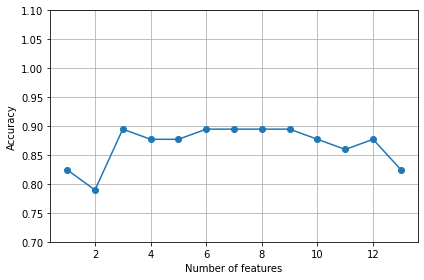

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=50,n_jobs = -1,random_state=1,min_samples_leaf=10)
# selecting features
sbs = SBS(rfc, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

In [ ]:
rfc.fit(X_train_std, y_train)
print('Training accuracy:', rfc.score(X_train_std, y_train))
print('Test accuracy:', rfc.score(X_test_std, y_test))

Training accuracy: 0.8854625550660793
Test accuracy: 0.8026315789473685


In [ ]:
y_pred = rfc.predict(X_test_std[:,:])
print('Misclassified examples: %d' % (y_test != y_pred).sum())
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

Misclassified examples: 15


array([[26,  9],
       [ 6, 35]])

In [ ]:
sbs.subsets_

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11),
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11),
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 11),
 (1, 2, 3, 4, 5, 6, 7, 8, 11),
 (1, 2, 3, 4, 5, 6, 8, 11),
 (2, 3, 4, 5, 6, 8, 11),
 (2, 3, 5, 6, 8, 11),
 (2, 3, 5, 8, 11),
 (2, 3, 8, 11),
 (2, 8, 11),
 (2, 8),
 (8,)]